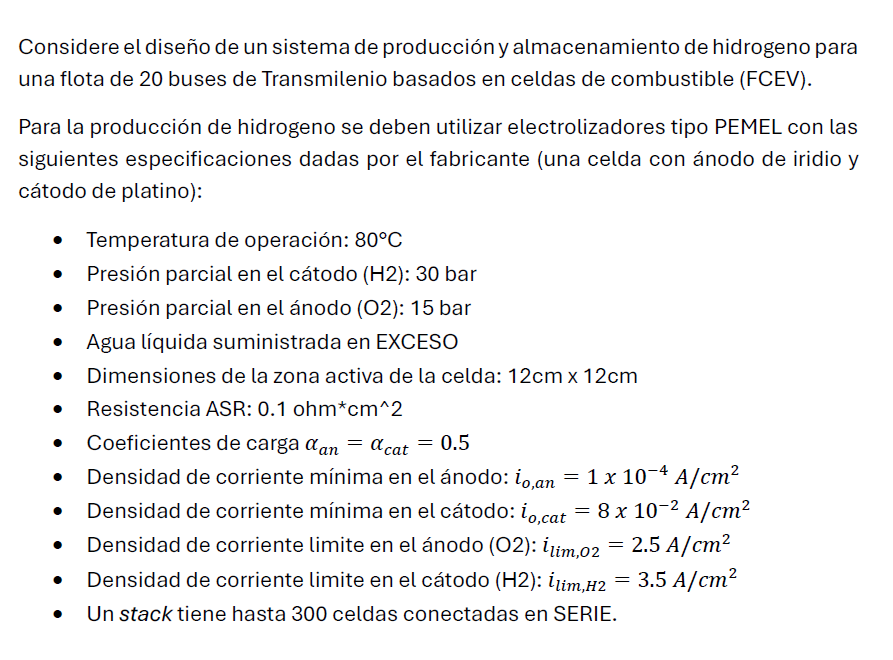

In [100]:
import numpy as np
import matplotlib.pyplot as plt 


In [101]:
# Constantes
F = 96485.33  # C/mol
R = 8.31446   # J/mol K
n_b = 20 #numero de buses
T_op = 80 + 273.15   #K
P_cat = 30 #bar H2
P_an = 15 # bar O2
A = 12.0 * 12.0 #cm2
ASR = 0.1 #ohm*cm2
alpha_an = 0.5
alpha_cat = 0.5
i_0_an = 1e-4 #A/cm2
i_0_cat = 8e-2 #A/cm2
i_lim_02 = 2.5 #A/cm2
i_lim_H2 = 3.5 #A/cm2

n_celdas = 300 # numero de celdas 



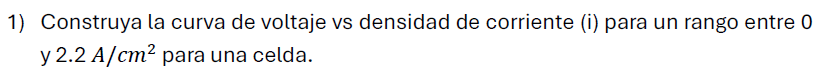

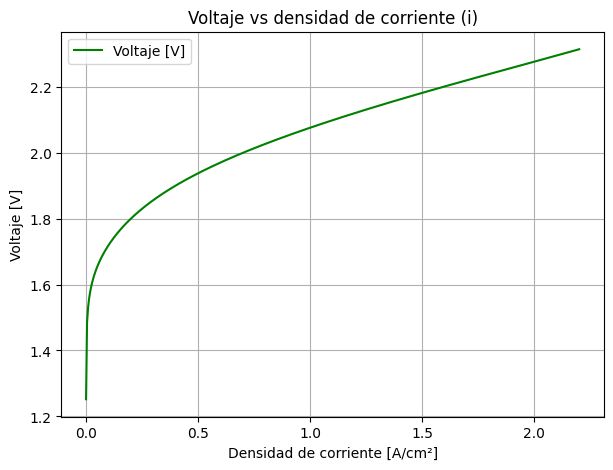

In [102]:
# Densidad de corriente
i = np.linspace(1e-6, 2.2, 500)  # de 0 a 2.2 A/cm2 (evitar log(0))

# Voltaje de Nernst
E_N = (1.229 - 0.0009*(T_op-298.15) +
       ((R*T_op)/(2*F)) * np.log(P_cat * np.sqrt(P_an)))

# Sobrepotencial de activación
eta_act = (R*T_op/(alpha_an*F))*np.arcsinh(i/(2*i_0_an)) + \
          (R*T_op/(alpha_an_cat*F))*np.arcsinh(i/(2*i_0_cat))

# Sobrepotencial óhmico
eta_ohm = i * ASR

# Sobrepotencial de difusión (con protección numérica)
eps = 1e-12
ratio_O2 = np.clip(1.0 - i/i_lim_02, eps, None)
ratio_H2 = np.clip(1.0 - i/i_lim_H2, eps, None)
eta_diff = - (R*T_op/(2*F)) * (0.5*np.log(ratio_O2) + 1.0*np.log(ratio_H2))

# Voltaje total
E = E_N + eta_act + eta_ohm + eta_diff

# Graficar
plt.figure(figsize=(7,5))
plt.plot(i, E, label="Voltaje [V]", color = "green")
plt.xlabel("Densidad de corriente [A/cm²]")
plt.ylabel("Voltaje [V]")
plt.title("Voltaje vs densidad de corriente (i)")
plt.legend()
plt.grid(True)
plt.show()

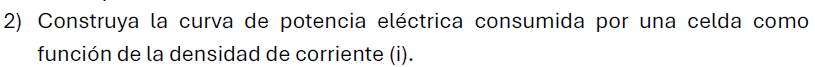

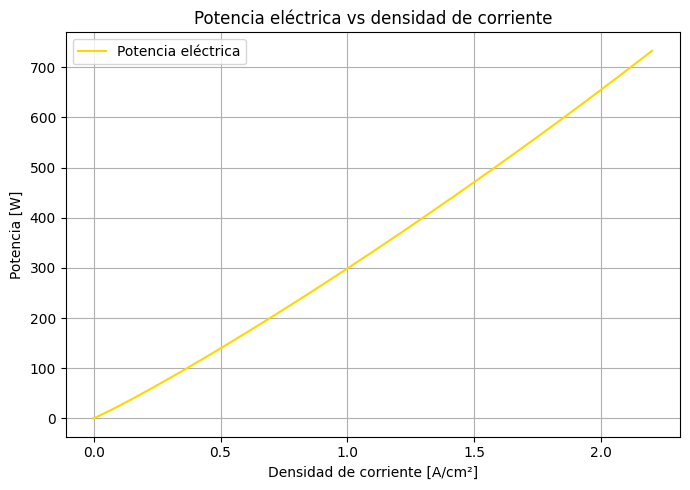

In [103]:
# Corriente total [A]
I = i * A

# Potencia eléctrica [W]
P_elec = E * I


plt.figure(figsize=(7,5))
plt.plot(i, P_elec, color="gold", label="Potencia eléctrica")
plt.xlabel("Densidad de corriente [A/cm²]")
plt.ylabel("Potencia [W]")
plt.title("Potencia eléctrica vs densidad de corriente")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

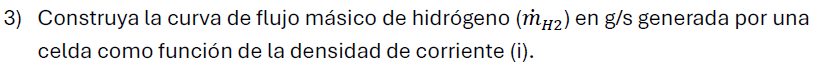

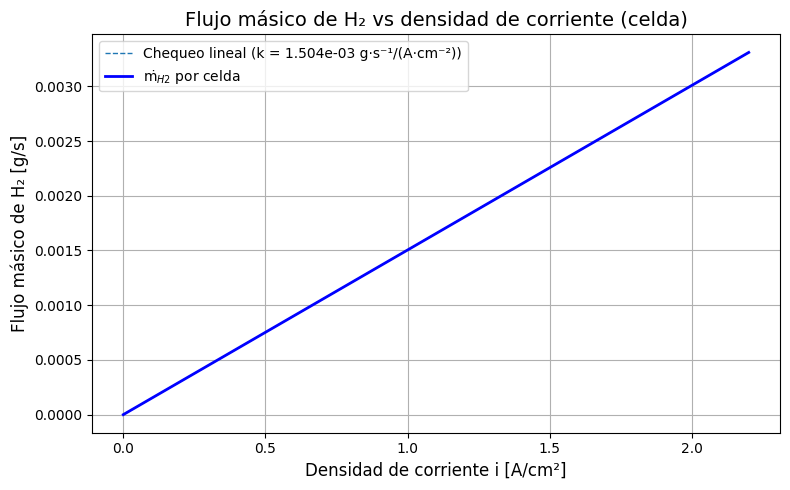

In [104]:
MW_H2 = 2.0159e-3   # kg/mol (= 2.0159 g/mol)
z = 2
eta_F = 1.0         # eficiencia farádica (≈1 para PEM bien operado)

# Flujo molar y másico
n_dot = eta_F * I / (z * F)               # Flujo molar [mol/s]
m_dot_g_s = n_dot * MW_H2 * 1000          # Flujo másico [g/s]

# (Opcional) constante de proporcionalidad para verificación: m_dot = k * i
k = (Dim_zon_act * MW_H2 * 1000) / (z * F)  # [g/s] por [A/cm^2]

# Graficar
plt.figure(figsize=(8,5))
plt.plot(i, k*i, "--", lw=1, label=f"Chequeo lineal (k = {k:.3e} g·s⁻¹/(A·cm⁻²))")
plt.plot(i, m_dot_g_s, color="blue", lw=2, label="ṁ$_{H2}$ por celda")
plt.xlabel("Densidad de corriente i [A/cm²]", fontsize=12)
plt.ylabel("Flujo másico de H₂ [g/s]", fontsize=12)
plt.title("Flujo másico de H₂ vs densidad de corriente (celda)", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

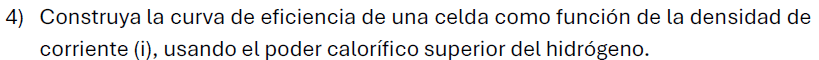

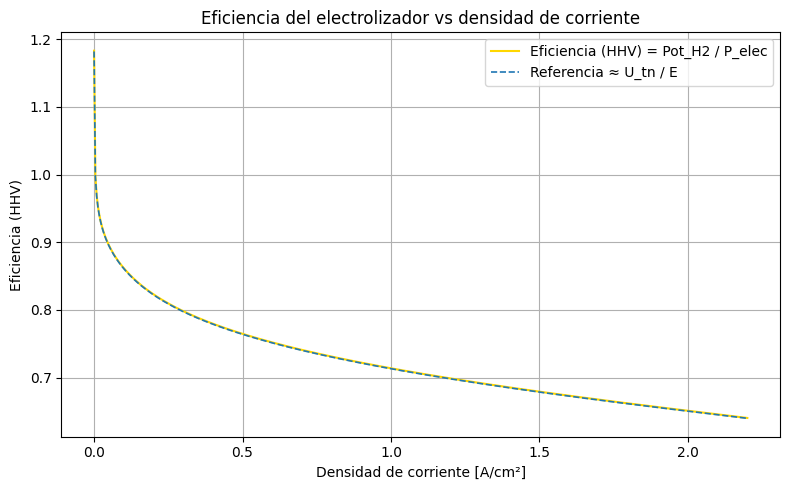

In [105]:
# Poder calorífico superior del H2 [J/kg]
LHV_H2 = 141.8e6
# Potencia química del H2 (usando HHV) y eficiencia
Pot_H2 = LHV_H2 * (m_dot_g_s/1000.0)   # [W] (g/s -> kg/s)
eficiencia1 = Pot_H2 / P_elec          # adimensional

# Curva de referencia teórica U_tn/E (chequeo rápido)
U_tn = 1.48  # V (aprox. HHV/2F)
eta_teor = U_tn / E

# Graficar
plt.figure(figsize=(8,5))
plt.plot(i, eficiencia1, color="gold", label="Eficiencia (HHV) = Pot_H2 / P_elec")
plt.plot(i, eta_teor, '--', lw=1.2, label="Referencia ≈ U_tn / E")
plt.xlabel("Densidad de corriente [A/cm²]")
plt.ylabel("Eficiencia (HHV)")
plt.title("Eficiencia del electrolizador vs densidad de corriente")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

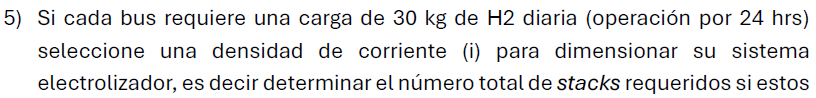
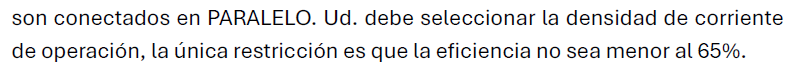

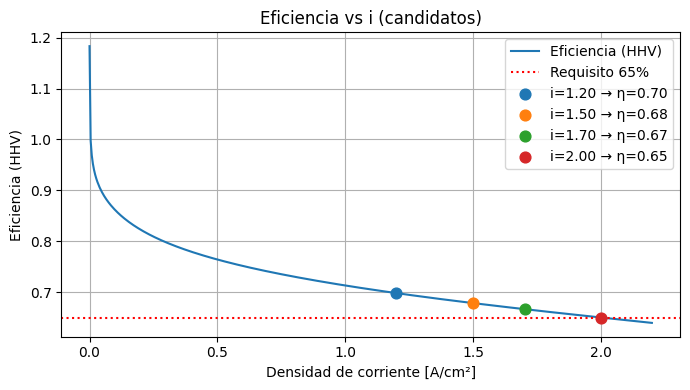

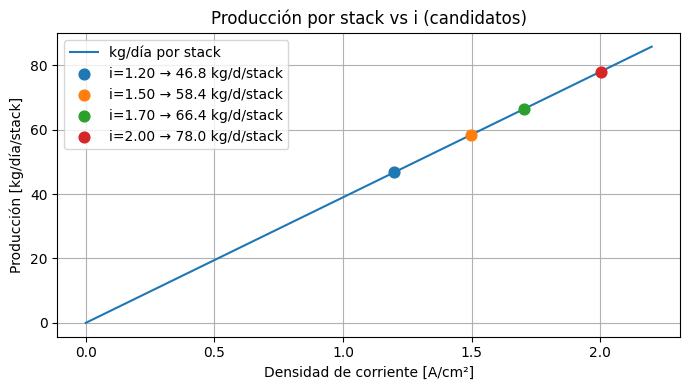

===== Comparación (sistema dimensionado en paralelo) =====
 i_sel  η(HHV)   E[V]    I[A]   V_stack[V]  kg/d/stack  stacks  kg/d total   P_stack[kW]  P_total[kW]  I_bus[A]  kWh/kg(sys)
 1.20   0.699   2.12    172.7       635.9         46.8      13       607.9        109.8       1427.6      2245         56.4
 1.50   0.679   2.18    215.9       654.3         58.4      11       642.9        141.2       1553.6      2374         58.0
 1.70   0.667   2.22    245.1       666.0         66.4      10       663.6        163.2       1632.1      2451         59.0
 2.00   0.651   2.28    288.2       682.8         78.0       8       624.4        196.8       1574.5      2306         60.5

===== Dimensionamiento FINAL con i = 1.50 A/cm² =====
i seleccionada            : 1.499 A/cm²
Eficiencia (HHV)          : 0.679
Voltaje por celda (E)     : 2.181 V
Corriente por celda (I)   : 215.9 A

-- Un stack (300 celdas en SERIE) --
Voltaje del stack         : 654.3 V
Potencia por celda        : 0.47 kW
Potencia 

In [ ]:
# Producción por stack y comparación de candidatos (PARALELO)
# -------------------------
kg_dia_stack_curve = (m_dot_g_s * n_celdas) * 86400.0 / 1000.0  # [kg/día] por stack
kg_dia_total = n_b * 30.0  # 20 buses * 30 kg/día = 600 kg/día
mask_ok = (eficiencia1 >= 0.65)
idx_ok = np.where(mask_ok)[0]
if idx_ok.size == 0:
    raise RuntimeError("No hay puntos con eficiencia >= 65% en el rango de i.")

# Densidades a evaluar 
i_candidatos = np.array([1.20, 1.50, 1.70, 2.00])  # A/cm2

res = []
for it in i_candidatos:
    # índice del i factible más cercano al candidato (η ≥ 65%)
    j = idx_ok[np.argmin(np.abs(i[idx_ok] - it))]

    # Magnitudes por celda/stack en ese punto
    i_sel_j        = float(i[j])
    eta_j          = float(eficiencia1[j])
    E_celda_j      = float(E[j])
    I_celda_j      = float(I[j])
    kg_dia_stack_j = float(kg_dia_stack_curve[j])           # [kg/día] por stack
    P_stack_kW_j   = float((P_elec[j] * n_celdas) / 1000.0) # [kW] por stack
    V_stack_j      = float(E_celda_j * n_celdas)            # [V] por stack

    # Dimensionamiento en PARALELO para satisfacer la demanda total
    stacks_nec_j   = int(np.ceil(kg_dia_total / max(kg_dia_stack_j, 1e-12)))
    kg_d_total_j   = stacks_nec_j * kg_dia_stack_j          # [kg/día] total del sistema
    P_total_kW_j   = stacks_nec_j * P_stack_kW_j            # [kW] total del sistema
    I_bus_A_j      = stacks_nec_j * I_celda_j               # [A] bus DC (corriente suma en paralelo)
    kWh_kg_sys_j   = (P_total_kW_j * 24.0) / max(kg_d_total_j, 1e-12)

    res.append({
        "i_sel": i_sel_j,
        "eta": eta_j,
        "E_celda": E_celda_j,
        "I_celda": I_celda_j,
        "V_stack": V_stack_j,
        "kg_dia_stack": kg_dia_stack_j,
        "P_stack_kW": P_stack_kW_j,
        "stacks": stacks_nec_j,
        "kg_d_total": kg_d_total_j,
        "P_total_kW": P_total_kW_j,
        "I_bus_A": I_bus_A_j,
        "kWh_kg_sys": kWh_kg_sys_j,
    })

# Eficiencia con marcadores
plt.figure(figsize=(7,4))
plt.plot(i, eficiencia1, label="Eficiencia (HHV)")
plt.axhline(0.65, color='r', ls=':', label='Requisito 65%')
for r in res:
    plt.scatter(r["i_sel"], r["eta"], s=60, zorder=3,
                label=f"i={r['i_sel']:.2f} → η={r['eta']:.2f}")
plt.xlabel("Densidad de corriente [A/cm²]"); plt.ylabel("Eficiencia (HHV)")
plt.title("Eficiencia vs i (candidatos)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# Producción por stack con marcadores
plt.figure(figsize=(7,4))
plt.plot(i, kg_dia_stack_curve, label="kg/día por stack")
for r in res:
    plt.scatter(r["i_sel"], r["kg_dia_stack"], s=60, zorder=3,
                label=f"i={r['i_sel']:.2f} → {r['kg_dia_stack']:.1f} kg/d/stack")
plt.xlabel("Densidad de corriente [A/cm²]"); plt.ylabel("Producción [kg/día/stack]")
plt.title("Producción por stack vs i (candidatos)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# ===== Tabla comparativa en PARALELO (sistema dimensionado) =====
print("===== Comparación (sistema dimensionado en paralelo) =====")
print(" i_sel  η(HHV)   E[V]    I[A]   V_stack[V]  kg/d/stack  stacks  kg/d total   P_stack[kW]  P_total[kW]  I_bus[A]  kWh/kg(sys)")
for r in res:
    print(f" {r['i_sel']:>4.2f}  {r['eta']:>6.3f}  {r['E_celda']:>5.2f}  {r['I_celda']:>7.1f}  "
          f"{r['V_stack']:>10.1f}  {r['kg_dia_stack']:>11.1f}  {r['stacks']:>6d}  "
          f"{r['kg_d_total']:>10.1f}  {r['P_stack_kW']:>11.1f}  {r['P_total_kW']:>11.1f}  "
          f"{r['I_bus_A']:>8.0f}  {r['kWh_kg_sys']:>11.1f}")

# -------------------------
# Dimensionamiento FINAL (i elegida = 1.50 A/cm²)
# Serie (stack) + Paralelo (sistema)
# -------------------------
i_target = 1.50
j = idx_ok[np.argmin(np.abs(i[idx_ok] - i_target))]  # punto factible más cercano (η≥65%)

# ---- Magnitudes por celda en el punto elegido ----
i_sel       = i[j]
E_sel       = E[j]
I_sel       = I[j]
P_celda_sel = P_elec[j]
eta_sel     = eficiencia1[j]

# ---- SERIE: un stack de 300 celdas ----
kg_dia_stack = kg_dia_stack_curve[j]    # [kg/día] por stack
P_stack_W    = P_elec[j] * n_celdas     # [W] por stack
V_stack      = E_sel * n_celdas         # [V] del stack

# ---- PARALELO: sistema para cumplir demanda ----
stacks_necesarios = int(np.ceil(kg_dia_total / max(kg_dia_stack, 1e-12)))
kg_d_total = stacks_necesarios * kg_dia_stack                  # [kg/día]
P_total_W  = stacks_necesarios * P_stack_W                     # [W]
V_bus      = V_stack                                           # [V]
I_bus_A    = stacks_necesarios * I_sel                         # [A]
kWh_kg_final = (P_total_W * 24.0 / 1000.0) / max(kg_d_total, 1e-12)

print("\n===== Dimensionamiento FINAL con i = 1.50 A/cm² =====")
print(f"i seleccionada            : {i_sel:.3f} A/cm²")
print(f"Eficiencia (HHV)          : {eta_sel:.3f}")
print(f"Voltaje por celda (E)     : {E_sel:.3f} V")
print(f"Corriente por celda (I)   : {I_sel:.1f} A")

print("\n-- Un stack (300 celdas en SERIE) --")
print(f"Voltaje del stack         : {V_stack:.1f} V")
print(f"Potencia por celda        : {P_celda_sel/1000:.2f} kW")
print(f"Potencia por stack        : {P_stack_W/1000:.2f} kW")
print(f"Producción por stack      : {kg_dia_stack:.2f} kg/día")

print("\n-- Sistema (stacks en PARALELO) --")
print(f"Demanda total             : {kg_dia_total:.0f} kg/día")
print(f"Stacks requeridos (||)    : {stacks_necesarios} stacks")
print(f"Producción total          : {kg_d_total:.1f} kg/día")
print(f"Potencia total sistema    : {P_total_W/1e6:.3f} MW")
print(f"Bus DC (V x A)            : {V_bus:.0f} V × {I_bus_A:.0f} A")
print(f"Consumo eléctrico esp.    : {kWh_kg_final:.1f} kWh/kg  (≈39.4 kWh/kg teórico HHV como ref.)")

In [107]:
# --- Magnitudes eléctricas en i_sel ---
P_celda_sel = P_elec[idx_sel]           # [W] por celda
P_stack_W = P_celda_sel * n_celdas      # [W] por stack (300 celdas en serie)
V_stack = E_sel * n_celdas              # [V] del stack (útil para diseño DC)

# --- Demanda y número de stacks en paralelo ---
kg_dia_por_bus = 30.0
kg_dia_total = n_b * kg_dia_por_bus     # 20*30 = 600 kg/día

m_dot_stack_g_s = m_dot_g_s[idx_sel] * n_celdas         # [g/s] por stack
kg_dia_stack = m_dot_stack_g_s * 86400.0 / 1000.0       # [kg/día] por stack
stacks_necesarios = int(np.ceil(kg_dia_total / kg_dia_stack))

# --- Potencia total del sistema ---
P_total_W = P_stack_W * stacks_necesarios               # [W]

print("===== Potencia requerida =====")
print(f"i seleccionada           : {i_sel:.3f} A/cm²")
print(f"Eficiencia (HHV)         : {eficiencia1[idx_sel]:.3f}")
print(f"Voltaje por celda (E)    : {E_sel:.3f} V")
print(f"Corriente por celda (I)  : {I_sel:.2f} A")
print(f"Voltaje del stack        : {V_stack:.1f} V")
print(f"Potencia por celda       : {P_celda_sel/1000:.2f} kW")
print(f"Potencia por stack       : {P_stack_W/1000:.2f} kW")
print(f"Producción por stack     : {kg_dia_stack:.2f} kg/día")
print(f"Stacks requeridos (||)   : {stacks_necesarios}")
print(f"Potencia total sistema   : {P_total_W/1e6:.3f} MW")

===== Potencia requerida =====
i seleccionada           : 1.499 A/cm²
Eficiencia (HHV)         : 0.714
Voltaje por celda (E)    : 2.181 V
Corriente por celda (I)  : 215.86 A
Voltaje del stack        : 654.3 V
Potencia por celda       : 0.30 kW
Potencia por stack       : 89.74 kW
Producción por stack     : 39.02 kg/día
Stacks requeridos (||)   : 16
Potencia total sistema   : 1.436 MW


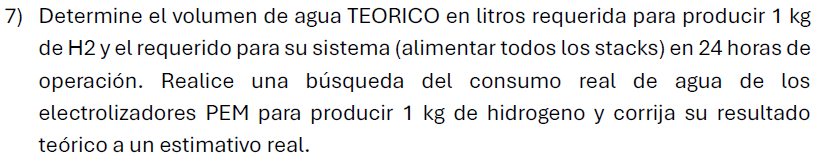

In [108]:
# --- Datos fisicoquímicos (mantengo tus nombres y estilo) ---
MW_H2   = 2.0159e-3      # kg/mol
MW_H2O  = 18.01528e-3    # kg/mol
rho_H2O = 0.997          # kg/L (~25 °C; si quieres, ajusta según T del agua de alimentación)

# --- Demanda diaria (ya definida en pasos previos, la recalculo aquí por claridad) ---
kg_dia_por_bus = 30.0
kg_dia_total   = n_b * kg_dia_por_bus     # 20 * 30 = 600 kg/día

# --- 1) Consumo TEÓRICO ---
kg_H2O_por_kgH2   = MW_H2O / MW_H2                      # ≈ 8.936 kg agua / kg H2
L_por_kgH2_teo    = kg_H2O_por_kgH2 / rho_H2O           # ≈ 8.96 L agua / kg H2
L_dia_total_teo   = L_por_kgH2_teo * kg_dia_total       # para la demanda de 600 kg/día

# Si ya calculaste stacks_necesarios y kg_dia_stack, usa la capacidad real del sistema
try:
    kg_dia_sistema = stacks_necesarios * kg_dia_stack   # [kg/día] por el dimensionamiento real
except NameError:
    kg_dia_sistema = kg_dia_total

L_dia_sistema_teo = L_por_kgH2_teo * kg_dia_sistema

# 2) Consumo REAL (estimado)
# (a) Agua de proceso (desionizada) típica reportada por NREL ≈ 2.939 gal/kg ≈ 11.1 L/kg
L_por_kgH2_real_proc = 11.1

# (b) Agua total (proceso + purificación/enfriamiento). Rango sugerido por RMI: 9 + (10 a 20) L/kg
L_por_kgH2_real_total_min = 19.0   # L/kg
L_por_kgH2_real_total_max = 29.0   # L/kg
L_por_kgH2_real_total_mid = 24.0   # valor medio para estimado puntual

# Totales diarios para la demanda objetivo (600 kg/d) y para el sistema dimensionado
L_dia_total_real_proc    = L_por_kgH2_real_proc    * kg_dia_total
L_dia_total_real_totalLo = L_por_kgH2_real_total_min * kg_dia_total
L_dia_total_real_totalHi = L_por_kgH2_real_total_max * kg_dia_total
L_dia_total_real_totalMd = L_por_kgH2_real_total_mid * kg_dia_total

L_dia_sist_real_proc     = L_por_kgH2_real_proc    * kg_dia_sistema
L_dia_sist_real_totalLo  = L_por_kgH2_real_total_min * kg_dia_sistema
L_dia_sist_real_totalHi  = L_por_kgH2_real_total_max * kg_dia_sistema
L_dia_sist_real_totalMd  = L_por_kgH2_real_total_mid * kg_dia_sistema

# --- Reporte ---
print("===== Consumo de agua para electrólisis (por estequiometría y estimación real) =====")
print(f"Teórico por 1 kg H2         : {L_por_kgH2_teo:.2f} L/kg")
print(f"Teórico demanda 600 kg/d    : {L_dia_total_teo:,.0f} L/día")
print(f"Teórico sistema dimensionado: {L_dia_sistema_teo:,.0f} L/día")

print("\n-- Estimación REAL (a) Agua de proceso --")
print(f"Real (proceso) por 1 kg H2  : {L_por_kgH2_real_proc:.1f} L/kg")
print(f"Real (proceso) 600 kg/d     : {L_dia_total_real_proc:,.0f} L/día")
print(f"Real (proceso) sistema      : {L_dia_sist_real_proc:,.0f} L/día")

print("\n-- Estimación REAL (b) Agua total (proceso+purif.+enfriamiento) --")
print(f"Real (total) por 1 kg H2    : {L_por_kgH2_real_total_min:.0f}–{L_por_kgH2_real_total_max:.0f} L/kg (usar ~{L_por_kgH2_real_total_mid:.0f} L/kg como punto medio)")
print(f"Real (total) 600 kg/d       : {L_dia_total_real_totalLo:,.0f} – {L_dia_total_real_totalHi:,.0f} L/día (≈ {L_dia_total_real_totalMd:,.0f} L/día medio)")
print(f"Real (total) sistema        : {L_dia_sist_real_totalLo:,.0f} – {L_dia_sist_real_totalHi:,.0f} L/día (≈ {L_dia_sist_real_totalMd:,.0f} L/día medio)")

===== Consumo de agua para electrólisis (por estequiometría y estimación real) =====
Teórico por 1 kg H2         : 8.96 L/kg
Teórico demanda 600 kg/d    : 5,378 L/día
Teórico sistema dimensionado: 5,597 L/día

-- Estimación REAL (a) Agua de proceso --
Real (proceso) por 1 kg H2  : 11.1 L/kg
Real (proceso) 600 kg/d     : 6,660 L/día
Real (proceso) sistema      : 6,931 L/día

-- Estimación REAL (b) Agua total (proceso+purif.+enfriamiento) --
Real (total) por 1 kg H2    : 19–29 L/kg (usar ~24 L/kg como punto medio)
Real (total) 600 kg/d       : 11,400 – 17,400 L/día (≈ 14,400 L/día medio)
Real (total) sistema        : 11,863 – 18,107 L/día (≈ 14,985 L/día medio)


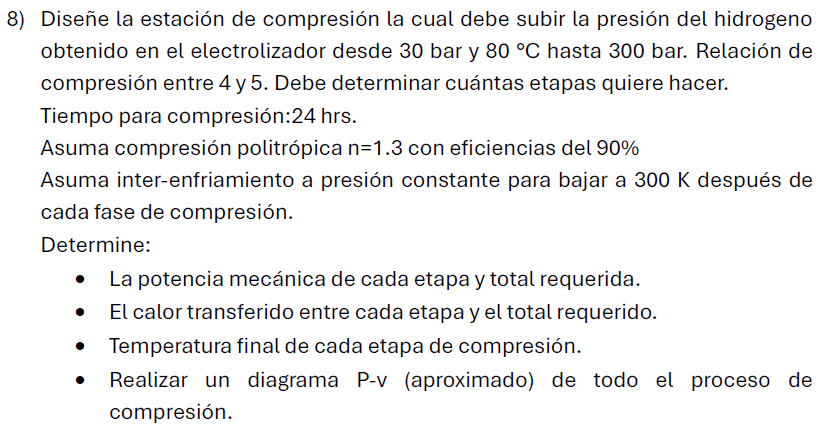